### Introduction
This project aims to scrape the information of top 250 movies on IMDb from IMDb website. Information includes the ranking of the movie, the movie name, its year of release, its IMDb rating, the movie page url, and its poster from the list page. Then by looping through the url links of each movie, I will scrape the movie's rating (PG, PG-13, R, etc.), length, genre, description, director name, writers, and stars.

### Scope
#### Problems
Some interesting problems I expect to solve from this project:
1. Is there an association between movie ratings and the director? Movie ratings and the stars?
2. Which main actor/actress appears the most?
3. Which director directed the most of the top 250 movies?
4. Association between the ranking and IMDb rating? Ranking and movie rating?
5. The most common genre of the top 250 movies. Any association between genre and movie rating
6. Association between length of the movie and IMDb ranking.

#### Goals
To learn more about the IMDb rating and the movies. Discover the relationships of different factors that make these movies into top 250.

#### Data
IMDb Top 250 Movies website page: https://www.imdb.com/chart/top

#### Analysis
1. Description
2. Detection
3. Optimization

#### Issues
There are only 

In [120]:
import re
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)

In [ ]:
# pull in website source code
url = 'https://www.imdb.com/chart/top'

page = requests.get(url)
soup = BeautifulSoup(page.text, 'html.parser')

### Scrape List Page

In [3]:
# create a list with all ranking
ranking = [i for i in range(1, 251)]

In [17]:
# extract the source code for the table
table = soup.find('tbody', attrs = {'class': 'lister-list'})
# table

In [18]:
# all movie titles are inside of <a> tage, we can extract movie titles by using table.find_all('a')
title_column = table.find_all('a')
movie_titles = []
for title in title_column:
    # we find that there is a ' \n' in between every title, we will skip this
    if title.get_text() == ' \n':
        continue
    else:
        movie_titles.append(title.get_text())
# movie_titles

In [7]:
# test to see if the length of movie_titles equals to 250
len(movie_titles)

250

In [19]:
# extract the release year
years_column = table.find_all('span' , attrs = {'class': 'secondaryInfo'})
release_year = []
for year in years_column:
    if year.get_text() == ' \n':
        continue
    else:
        cleaned = year.get_text().replace('(', '')
        cleaned = cleaned.replace(')', '')
        release_year.append(cleaned)

release_year[0]

'1994'

In [12]:
len(release_year)

250

In [20]:
# extract imdb ratings
imdb_rating_column = table.find_all('strong')
imdb_rating = []
for rating in imdb_rating_column:
    if rating.get_text() == ' \n':
        continue
    else:
        imdb_rating.append(float(rating.get_text()))
imdb_rating[0]

9.2

In [21]:
len(imdb_rating)

250

In [25]:
# extract the url of each movie page
parent = table.find_all('td', {'class' : 'titleColumn'})
movie_url = []
base_url = 'https://www.imdb.com'
for item in parent:
    a = item.find('a')
    movie_url.append(base_url + a['href'])
movie_url[0]

'https://www.imdb.com/title/tt0111161/'

In [23]:
len(movie_url)

250

In [26]:
# create first dataframe with all the information we have extracted
# first create a dictionary
movie_dict = {
    'ranking': ranking,
    'movie_name': movie_titles,
    'release_year': release_year,
    'imdb_rating': imdb_rating,
    'movie_page_url': movie_url
}

# convert the dictionary into a dataframe
movies = pd.DataFrame(movie_dict)

movies.head()

,ranking,movie_name,release_year,imdb_rating,movie_page_url
0,1,The Shawshank Redemption,1994,9.2,https://www.imdb.com/title/tt0111161/
1,2,The Godfather,1972,9.1,https://www.imdb.com/title/tt0068646/
2,3,The Godfather: Part II,1974,9.0,https://www.imdb.com/title/tt0071562/
3,4,The Dark Knight,2008,9.0,https://www.imdb.com/title/tt0468569/
4,5,12 Angry Men,1957,8.9,https://www.imdb.com/title/tt0050083/


In [91]:
movies[movies.movie_name == 'Das Boot']

,ranking,movie_name,release_year,imdb_rating,movie_page_url
77,78,Das Boot,1981,8.3,https://www.imdb.com/title/tt0082096/


### Scrape Individual Movie Page

In [169]:
# first, extract the information from the first movie ('The Shawshank Redemption') page
movie_page = movie_url[0]
movie_page_info = requests.get(movie_page)
movie_soup = BeautifulSoup(movie_page_info.text, 'html.parser')

In [170]:
# movie rating
info_list = movie_soup.find_all('span', attrs = {'class': 'TitleBlockMetaData__ListItemText-sc-12ein40-2 jedhex'})
element_list = []
for element in info_list:
    element_list.append(element.get_text())

movie_rating = element_list[1]
movie_rating

'R'

In [171]:
# movie length
info_list1 = movie_soup.find_all('li', attrs={'class': 'ipc-inline-list__item'})
runtime = info_list1[2].get_text()
runtime

'2h 22m'

In [172]:
# movie genre
genre = movie_soup.find('a', attrs={'class': 'GenresAndPlot__GenreChip-sc-cum89p-3 LKJMs ipc-chip ipc-chip--on-baseAlt'})
genre = genre.get_text()
genre

'Drama'

In [173]:
# movie description
description = movie_soup.find('span', attrs={'class': 'GenresAndPlot__TextContainerBreakpointL-sc-cum89p-1 eqlIrG'})
description = description.get_text()
description

'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.'

In [174]:
# movie director
director = movie_soup.find('a', attrs={'class': 'ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link'}).get_text()
director

'Frank Darabont'

In [175]:
# writers
writer_list = []
writers = movie_soup.find_all('a', attrs={'class': 'ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link'})
for writer in writers[:2]:
    writer_list.append(writer.get_text())
writer_list

# convert list into one string
delimiter = '|'
movie_writer = delimiter.join(writer_list)
movie_writer

'Frank Darabont|Stephen King'

In [176]:
# two main actors/actress
actor_list = []
actors = movie_soup.find_all('a', attrs={'class': 'StyledComponents__ActorName-sc-y9ygcu-1 ezTgkS'})
for actor in actors[:2]:
    actor_list.append(actor.get_text())

# convert list into a string
main_actors = delimiter.join(actor_list)
main_actors

'Tim Robbins|Morgan Freeman'

In [177]:
def get_page_info(url):
    page_url = url
    response = requests.get(page_url)
    if response.status_code != 200:
        raise Exception('Failed to load page {}'.format(page_url))
    movie_soup = BeautifulSoup(response.text, 'html.parser')
    return movie_soup

In [189]:
# now we can build a function that scrape these information from every movie page
def get_movie_info(movie_url):
    
    movie_soup = get_page_info(movie_url)
    
    # movie rating & runtime
    ## on some movie pages, there is no rating, thus I use if statement so these pages will return 'not rated'
    ## when there is no rating, info_list1[2] is not runtime, instead runtime is at info_list1[1]
    rating = [element.get_text() for element in movie_soup.find_all('span', attrs = {'class': 'TitleBlockMetaData__ListItemText-sc-12ein40-2 jedhex'})]
    info_list1 = movie_soup.find_all('li', attrs={'class': 'ipc-inline-list__item'})
    if len(rating) < 2:
        rating = 'Not Rated'
        runtime = info_list1[1].get_text()
    else:
        rating = rating[1]
        runtime = info_list1[2].get_text()
        
    # genre
    genre = movie_soup.find('a', attrs={'class': 'GenresAndPlot__GenreChip-sc-cum89p-3 LKJMs ipc-chip ipc-chip--on-baseAlt'}).get_text()
        
    # summary
    summary = movie_soup.find('span', attrs={'class': 'GenresAndPlot__TextContainerBreakpointL-sc-cum89p-1 eqlIrG'}).get_text()
        
    # director
    director = movie_soup.find('a', attrs={'class': 'ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link'}).get_text()
        
    # writers
    writer_list = [writer.get_text() for writer in movie_soup.find_all('a', attrs={'class': 'ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link'})]
    writer_list = writer_list[:2]
    delimiter = '|'
    writers = delimiter.join(writer_list)
        
    #actors
    actor_list = [actor.get_text() for actor in movie_soup.find_all('a', attrs={'class': 'StyledComponents__ActorName-sc-y9ygcu-1 ezTgkS'})]
    actor_list = actor_list[:2]
    main_actors = delimiter.join(actor_list)
        
    return rating, runtime, genre, summary, director, writers, main_actors

In [190]:
get_movie_info(movie_url[0])

('R',
 '2h 22m',
 'Drama',
 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
 'Frank Darabont',
 'Frank Darabont|Stephen King',
 'Tim Robbins|Morgan Freeman')

In [180]:
get_movie_info(movie_url[3])

('PG-13',
 '2h 32m',
 'Action',
 'When the menace known as the Joker wreaks havoc and chaos on the people of Gotham, Batman must accept one of the greatest psychological and physical tests of his ability to fight injustice.',
 'Christopher Nolan',
 'Christopher Nolan|Jonathan Nolan',
 'Christian Bale|Heath Ledger')

In [193]:
get_movie_info(movie_url[239])

('not rated',
 '1h 57m',
 'Animation',
 'Warrior and pacifist Princess Nausicaä desperately struggles to prevent two warring nations from destroying themselves and their dying planet.',
 'Hayao Miyazaki',
 'Hayao Miyazaki|Hayao Miyazaki',
 'Sumi Shimamoto|Mahito Tsujimura')

In [194]:
movie_dict2 = {
    'runtime': [],
    'rating': [],
    'genre': [],
    'director': [],
    'writers': [],
    'main_actors': [],
    'summary': []
}

for i in range(len(movie_url)):
    details = get_movie_info(movie_url[i])
    
    movie_dict2['runtime'].append(details[1])
    movie_dict2['rating'].append(details[0])
    movie_dict2['genre'].append(details[2])
    movie_dict2['director'].append(details[4])
    movie_dict2['writers'].append(details[5])
    movie_dict2['main_actors'].append(details[6])
    movie_dict2['summary'].append(details[3])

In [195]:
movie_details_df = pd.DataFrame(movie_dict2)
movie_details_df.head()

,runtime,rating,genre,director,writers,main_actors,summary
0,2h 22m,R,Drama,Frank Darabont,Frank Darabont|Stephen King,Tim Robbins|Morgan Freeman,"Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency."
1,2h 55m,R,Crime,Francis Ford Coppola,Francis Ford Coppola|Mario Puzo,Marlon Brando|Al Pacino,The aging patriarch of an organized crime dynasty in postwar New York City transfers control of his clandestine empire to his reluctant youngest son.
2,3h 22m,R,Crime,Francis Ford Coppola,Francis Ford Coppola|Francis Ford Coppola,Al Pacino|Robert De Niro,"The early life and career of Vito Corleone in 1920s New York City is portrayed, while his son, Michael, expands and tightens his grip on the family crime syndicate."
3,2h 32m,PG-13,Action,Christopher Nolan,Christopher Nolan|Jonathan Nolan,Christian Bale|Heath Ledger,"When the menace known as the Joker wreaks havoc and chaos on the people of Gotham, Batman must accept one of the greatest psychological and physical tests of his ability to fight injustice."
4,1h 36m,Approved,Crime,Sidney Lumet,Sidney Lumet|Reginald Rose,Henry Fonda|Lee J. Cobb,The jury in a New York City murder trial is frustrated by a single member whose skeptical caution forces them to more carefully consider the evidence before jumping to a hasty verdict.


In [196]:
top250_movies = pd.concat([movies, movie_details_df], axis=1)
top250_movies.head(10)

,ranking,movie_name,release_year,imdb_rating,movie_page_url,runtime,rating,genre,director,writers,main_actors,summary
0,1,The Shawshank Redemption,1994,9.2,https://www.imdb.com/title/tt0111161/,2h 22m,R,Drama,Frank Darabont,Frank Darabont|Stephen King,Tim Robbins|Morgan Freeman,"Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency."
1,2,The Godfather,1972,9.1,https://www.imdb.com/title/tt0068646/,2h 55m,R,Crime,Francis Ford Coppola,Francis Ford Coppola|Mario Puzo,Marlon Brando|Al Pacino,The aging patriarch of an organized crime dynasty in postwar New York City transfers control of his clandestine empire to his reluctant youngest son.
2,3,The Godfather: Part II,1974,9.0,https://www.imdb.com/title/tt0071562/,3h 22m,R,Crime,Francis Ford Coppola,Francis Ford Coppola|Francis Ford Coppola,Al Pacino|Robert De Niro,"The early life and career of Vito Corleone in 1920s New York City is portrayed, while his son, Michael, expands and tightens his grip on the family crime syndicate."
3,4,The Dark Knight,2008,9.0,https://www.imdb.com/title/tt0468569/,2h 32m,PG-13,Action,Christopher Nolan,Christopher Nolan|Jonathan Nolan,Christian Bale|Heath Ledger,"When the menace known as the Joker wreaks havoc and chaos on the people of Gotham, Batman must accept one of the greatest psychological and physical tests of his ability to fight injustice."
4,5,12 Angry Men,1957,8.9,https://www.imdb.com/title/tt0050083/,1h 36m,Approved,Crime,Sidney Lumet,Sidney Lumet|Reginald Rose,Henry Fonda|Lee J. Cobb,The jury in a New York City murder trial is frustrated by a single member whose skeptical caution forces them to more carefully consider the evidence before jumping to a hasty verdict.
5,6,Schindler's List,1993,8.9,https://www.imdb.com/title/tt0108052/,3h 15m,R,Biography,Steven Spielberg,Steven Spielberg|Thomas Keneally,Liam Neeson|Ralph Fiennes,"In German-occupied Poland during World War II, industrialist Oskar Schindler gradually becomes concerned for his Jewish workforce after witnessing their persecution by the Nazis."
6,7,The Lord of the Rings: The Return of the King,2003,8.9,https://www.imdb.com/title/tt0167260/,3h 21m,PG-13,Action,Peter Jackson,Peter Jackson|J.R.R. Tolkien,Elijah Wood|Viggo Mortensen,Gandalf and Aragorn lead the World of Men against Sauron's army to draw his gaze from Frodo and Sam as they approach Mount Doom with the One Ring.
7,8,Pulp Fiction,1994,8.8,https://www.imdb.com/title/tt0110912/,2h 34m,R,Crime,Quentin Tarantino,Quentin Tarantino|Quentin Tarantino,John Travolta|Uma Thurman,"The lives of two mob hitmen, a boxer, a gangster and his wife, and a pair of diner bandits intertwine in four tales of violence and redemption."
8,9,"The Good, the Bad and the Ugly",1966,8.8,https://www.imdb.com/title/tt0060196/,2h 58m,R,Adventure,Sergio Leone,Sergio Leone|Luciano Vincenzoni,Clint Eastwood|Eli Wallach,A bounty hunting scam joins two men in an uneasy alliance against a third in a race to find a fortune in gold buried in a remote cemetery.
9,10,The Lord of the Rings: The Fellowship of the Ring,2001,8.8,https://www.imdb.com/title/tt0120737/,2h 58m,PG-13,Action,Peter Jackson,Peter Jackson|J.R.R. Tolkien,Elijah Wood|Ian McKellen,A meek Hobbit from the Shire and eight companions set out on a journey to destroy the powerful One Ring and save Middle-earth from the Dark Lord Sauron.


### EDA

In [164]:
top250_movies.dtypes

ranking             int64
movie_name         object
release_year       object
imdb_rating       float64
movie_page_url     object
runtime            object
rating             object
genre              object
director           object
writers            object
main_actors        object
summary            object
dtype: object

In [198]:
# convert runtime into minutes
top250_movies['runtime'] = top250_movies['runtime'].str.replace('h', '*60').str.replace(' ', '+').str.replace('m', '*1').apply(eval)

In [201]:
top250_movies.rename(columns={'runtime': 'runtime_in_minutes'}, inplace=True)

In [202]:
top250_movies.columns

Index(['ranking', 'movie_name', 'release_year', 'imdb_rating',
       'movie_page_url', 'runtime_in_minutes', 'rating', 'genre', 'director',
       'writers', 'main_actors', 'summary'],
      dtype='object')

In [203]:
top250_movies.describe(include='all')

,ranking,movie_name,release_year,imdb_rating,movie_page_url,runtime_in_minutes,rating,genre,director,writers,main_actors,summary
count,250.000000,250,250,250.000000,250,250.000000,250,250,250,250,250,250
unique,NaN,250,86,NaN,250,NaN,15,11,155,208,241,250
top,NaN,Once Upon a Time in the West,1995,NaN,https://www.imdb.com/title/tt0032553/,NaN,R,Drama,Martin Scorsese,Stanley Kubrick|Stanley Kubrick,Mark Hamill|Harrison Ford,"After John Nash, a brilliant but asocial mathematician, accepts secret work in cryptography, his life takes a turn for the nightmarish."
freq,NaN,1,8,NaN,1,NaN,100,70,7,6,3,1
mean,125.500000,NaN,NaN,8.261600,NaN,130.472000,NaN,NaN,NaN,NaN,NaN,NaN
std,72.312977,NaN,NaN,0.226119,NaN,32.560374,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,8.000000,NaN,45.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,63.250000,NaN,NaN,8.100000,NaN,109.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,125.500000,NaN,NaN,8.200000,NaN,127.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,187.750000,NaN,NaN,8.400000,NaN,147.750000,NaN,NaN,NaN,NaN,NaN,NaN


In [205]:
# I found that some movies already are 'Not Rated', I need to replace the s
top250_movies['rating'] = top250_movies.rating.str.replace('not rated', 'Not Rated')

### Data Analysis
#### Movie Ratings vs. Runtime

In [206]:
# use value_counts(normalize=True) on rating column to see the percentage of each movie rating
top250_movies.rating.value_counts(normalize=True)

R            0.400
Not Rated    0.140
PG           0.140
PG-13        0.124
Passed       0.060
G            0.060
Approved     0.048
Unrated      0.004
GP           0.004
TV-MA        0.004
TV-PG        0.004
TV-14        0.004
M            0.004
X            0.004
Name: rating, dtype: float64

In [207]:
import matplotlib.pyplot as plt
import seaborn as sns

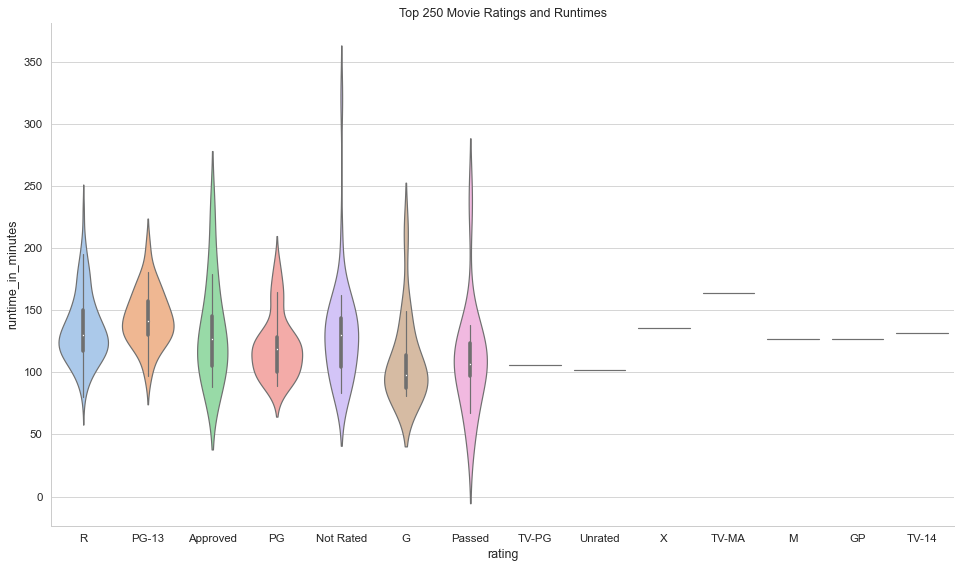

In [241]:
# rating vs. runtime boxplot
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.3)
ax1 = sns.catplot(kind='violin', data=top250_movies, x='rating', y='runtime_in_minutes', palette='pastel')
ax1.fig.set_figwidth(15)
ax1.fig.set_figheight(8)
plt.title('Top 250 Movie Ratings and Runtimes')
plt.show()

From the violin plot above, we can see that among all top 250 movies:
1. the medians for each type of rating are very similar.
2. for R, PG_13, and PG movies, the runtimes are highly concentrated around the median runtime.
3. for Approved, Not Rated, G, and Passed, it is certain that there are outliers for the runtime, especially in Not Rated movies.

#### R Movies Genres vs. Runtime

In [227]:
new_df = top250_movies[top250_movies.rating == 'R']
new_df.head()

,ranking,movie_name,release_year,imdb_rating,movie_page_url,runtime_in_minutes,rating,genre,director,writers,main_actors,summary
0,1,The Shawshank Redemption,1994,9.2,https://www.imdb.com/title/tt0111161/,142,R,Drama,Frank Darabont,Frank Darabont|Stephen King,Tim Robbins|Morgan Freeman,"Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency."
1,2,The Godfather,1972,9.1,https://www.imdb.com/title/tt0068646/,175,R,Crime,Francis Ford Coppola,Francis Ford Coppola|Mario Puzo,Marlon Brando|Al Pacino,The aging patriarch of an organized crime dynasty in postwar New York City transfers control of his clandestine empire to his reluctant youngest son.
2,3,The Godfather: Part II,1974,9.0,https://www.imdb.com/title/tt0071562/,202,R,Crime,Francis Ford Coppola,Francis Ford Coppola|Francis Ford Coppola,Al Pacino|Robert De Niro,"The early life and career of Vito Corleone in 1920s New York City is portrayed, while his son, Michael, expands and tightens his grip on the family crime syndicate."
5,6,Schindler's List,1993,8.9,https://www.imdb.com/title/tt0108052/,195,R,Biography,Steven Spielberg,Steven Spielberg|Thomas Keneally,Liam Neeson|Ralph Fiennes,"In German-occupied Poland during World War II, industrialist Oskar Schindler gradually becomes concerned for his Jewish workforce after witnessing their persecution by the Nazis."
7,8,Pulp Fiction,1994,8.8,https://www.imdb.com/title/tt0110912/,154,R,Crime,Quentin Tarantino,Quentin Tarantino|Quentin Tarantino,John Travolta|Uma Thurman,"The lives of two mob hitmen, a boxer, a gangster and his wife, and a pair of diner bandits intertwine in four tales of violence and redemption."


In [232]:
len(new_df)

100

<Figure size 432x288 with 0 Axes>

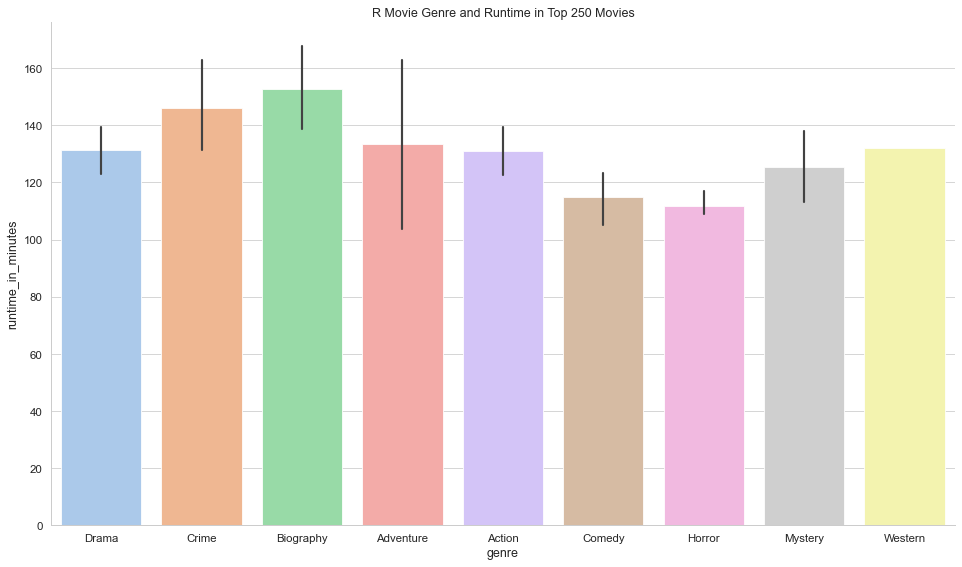

In [228]:
# runtime vs. genre in R movies
plt.clf()
sns.set_context('paper', font_scale=1.3)
sns.set_style('whitegrid')
ax2 = sns.catplot(kind='bar', data=new_df, x='genre', y='runtime_in_minutes', palette='pastel')
ax2.fig.set_figwidth(15)
ax2.fig.set_figheight(8)
plt.title('R Movie Genre and Runtime in Top 250 Movies')
plt.show()

From the bar graph above, we can see that:
1. The longest average runtime is biography movie among all R rated top 250 movies in IMDb.
2. The shortest aveage runtime is horror movie.

<Figure size 432x288 with 0 Axes>

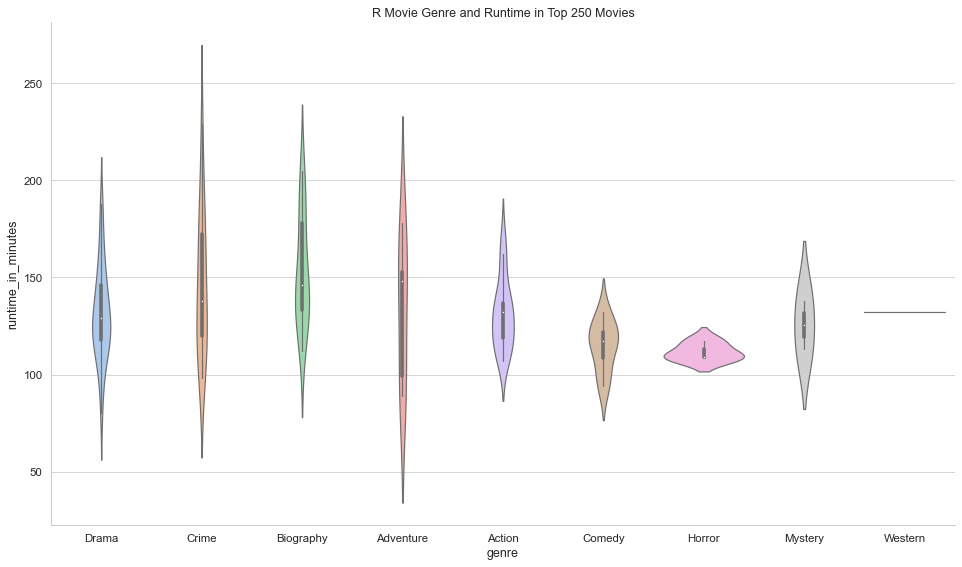

In [230]:
plt.clf()
sns.set_context('paper', font_scale=1.3)
sns.set_style('whitegrid')
ax2 = sns.catplot(kind='violin', data=new_df, x='genre', y='runtime_in_minutes', palette='pastel')
ax2.fig.set_figwidth(15)
ax2.fig.set_figheight(8)
plt.title('R Movie Genre and Runtime in Top 250 Movies')
plt.show()

From the violin plot above, we can see that:
1. Crime, Biography, and Adventure movies have extremely thin violin plots, indicating the runtimes are widely spreaded for these genres.
2. Even though the Biography genre has the longest average runtime, we can see here Adventure's median runtime is the highest among all genres.

In [231]:
# among the 100 R rated movies, 7 were directed by Martin Scorese
new_df.director.value_counts()

Martin Scorsese                     7
Quentin Tarantino                   5
Francis Ford Coppola                3
David Fincher                       3
Ridley Scott                        3
Sergio Leone                        3
Mel Gibson                          2
Steven Spielberg                    2
James Cameron                       2
Frank Darabont                      2
Sam Mendes                          2
Denis Villeneuve                    2
Joel Coen                           2
Roman Polanski                      2
Richard Linklater                   2
Guy Ritchie                         2
Clint Eastwood                      2
Stanley Kubrick                     2
Todd Phillips                       1
Oliver Hirschbiegel                 1
Damien Chazelle                     1
Martin McDonagh                     1
Tom McCarthy                        1
James Mangold                       1
Brian De Palma                      1
George Miller                       1
Gus Van Sant

In [233]:
martin_scorese = top250_movies[top250_movies.director == 'Martin Scorsese']
martin_scorese

,ranking,movie_name,release_year,imdb_rating,movie_page_url,runtime_in_minutes,rating,genre,director,writers,main_actors,summary
16,17,Goodfellas,1990,8.6,https://www.imdb.com/title/tt0099685/,146,R,Biography,Martin Scorsese,Martin Scorsese|Nicholas Pileggi,Robert De Niro|Ray Liotta,"The story of Henry Hill and his life in the mob, covering his relationship with his wife Karen Hill and his mob partners Jimmy Conway and Tommy DeVito in the Italian-American crime syndicate."
44,45,The Departed,2006,8.5,https://www.imdb.com/title/tt0407887/,151,R,Crime,Martin Scorsese,Martin Scorsese|William Monahan,Leonardo DiCaprio|Matt Damon,An undercover cop and a mole in the police attempt to identify each other while infiltrating an Irish gang in South Boston.
111,112,Taxi Driver,1976,8.2,https://www.imdb.com/title/tt0075314/,114,R,Crime,Martin Scorsese,Martin Scorsese|Paul Schrader,Robert De Niro|Jodie Foster,"A mentally unstable veteran works as a nighttime taxi driver in New York City, where the perceived decadence and sleaze fuels his urge for violent action."
141,142,The Wolf of Wall Street,2013,8.2,https://www.imdb.com/title/tt0993846/,180,R,Biography,Martin Scorsese,Martin Scorsese|Terence Winter,Leonardo DiCaprio|Jonah Hill,"Based on the true story of Jordan Belfort, from his rise to a wealthy stock-broker living the high life to his fall involving crime, corruption and the federal government."
144,145,Casino,1995,8.2,https://www.imdb.com/title/tt0112641/,178,R,Crime,Martin Scorsese,Martin Scorsese|Nicholas Pileggi,Robert De Niro|Sharon Stone,"A tale of greed, deception, money, power, and murder occur between two best friends: a mafia enforcer and a casino executive compete against each other over a gambling empire, and over a fast-living and fast-loving socialite."
150,151,Raging Bull,1980,8.1,https://www.imdb.com/title/tt0081398/,129,R,Biography,Martin Scorsese,Martin Scorsese|Jake LaMotta,Robert De Niro|Cathy Moriarty,"The life of boxer Jake LaMotta, whose violence and temper that led him to the top in the ring destroyed his life outside of it."
153,154,Shutter Island,2010,8.1,https://www.imdb.com/title/tt1130884/,138,R,Mystery,Martin Scorsese,Martin Scorsese|Laeta Kalogridis,Leonardo DiCaprio|Emily Mortimer,"In 1954, a U.S. Marshal investigates the disappearance of a murderer who escaped from a hospital for the criminally insane."


<Figure size 432x288 with 0 Axes>

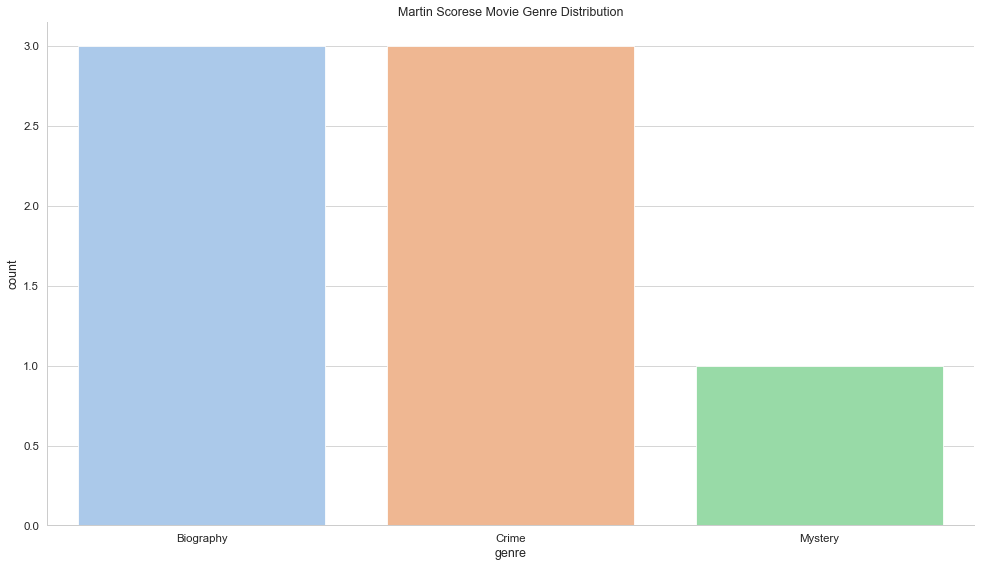

In [242]:
plt.clf()
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.3)
ax3 = sns.catplot(kind='count', data=martin_scorese, x='genre', palette="pastel", order=martin_scorese.genre.value_counts().index)
ax3.fig.set_figwidth(15)
ax3.fig.set_figheight(8)
plt.title('Martin Scorese Movie Genre Distribution')
plt.show()

Out of the seven R rated movies Martin Scorese directed, there are three Biography movies, three Crime movies, and one Mystery movie.

#### Movie Genre

<Figure size 432x288 with 0 Axes>

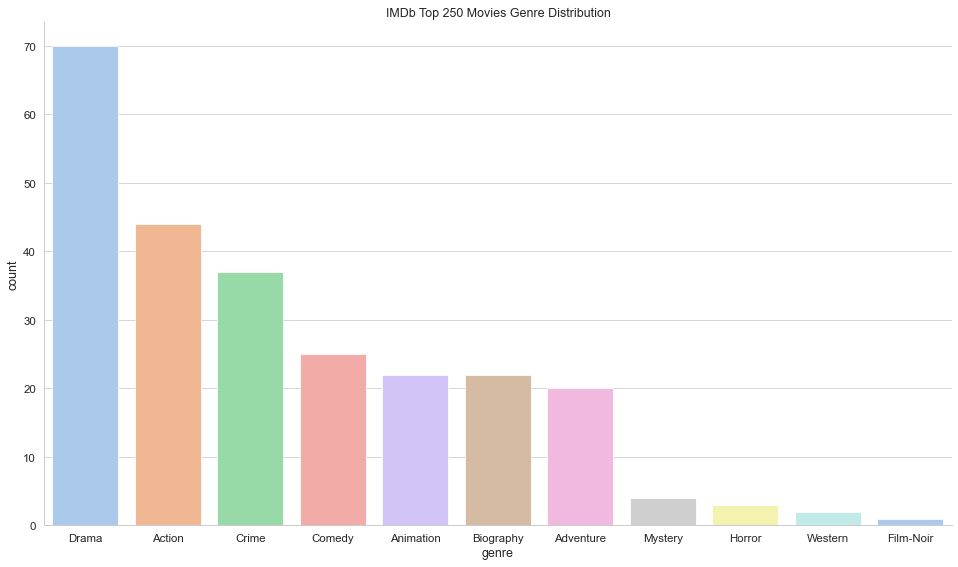

In [243]:
plt.clf()
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.3)
ax4 = sns.catplot(kind='count', data=top250_movies, x='genre', palette='pastel', order=top250_movies.genre.value_counts().index)
ax4.fig.set_figwidth(15)
ax4.fig.set_figheight(8)
plt.title('IMDb Top 250 Movies Genre Distribution')
plt.show()

From the bar chart above, we can see that out of 250 top movies on IMDb, drama movies account for 70 of them, the most for all genres. Mystery, horror, western, and film-noir are all under 10 movies.

<Figure size 432x288 with 0 Axes>

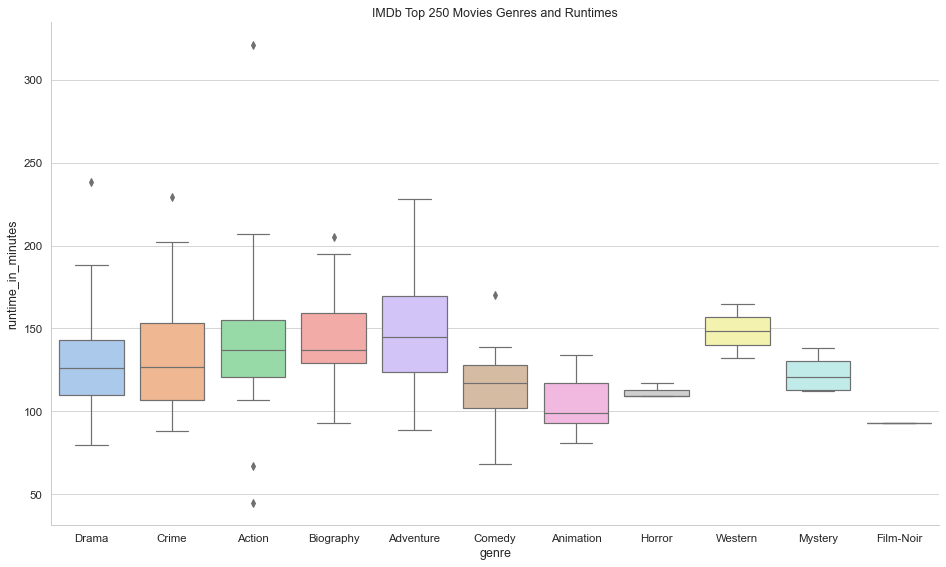

In [240]:
plt.clf()
sns.set_context('paper', font_scale=1.3)
sns.set_style('whitegrid')
ax2 = sns.catplot(kind='box', data=top250_movies, x='genre', y='runtime_in_minutes', palette='pastel')
ax2.fig.set_figwidth(15)
ax2.fig.set_figheight(8)
plt.title('IMDb Top 250 Movies Genres and Runtimes')
plt.show()

From the side-by-side box plot, we can see:
1. Drame, crime, action, biography, and adventure have similar interquartile range, indicating 50% of the runtimes of these genres' movies are in the 105- to 160-minute range.
2. Comedy and animation have much shorter runtime compared to the genres mentioned in number 1.
3. Horror, western, and mystery genres, each genre's runtime is closely distributed.